In [78]:
from pathlib import Path
from datetime import datetime, timedelta
from functools import reduce
from operator import add

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.dates as mdates

from music_league_graphs.scraper import create_dataframe
from music_league_graphs.spotify_api import SpotifyAPI

In [80]:
paths = [Path(f"../league_{i}") for i in range(1, 5)]

dfs: list[pd.DataFrame] = []
names: set[str] = set()

for path in paths:
    df, league_names = create_dataframe(path)
    df["league"] = path.stem
    dfs.append(df)
    names = names.union(set(league_names))

names = list(names)
df = pd.concat(dfs, axis=0, ignore_index=True)

df["round_score"] = df[names].sum(axis=1)
df["round_rank"] = df.groupby("round")["round_score"].rank(ascending=False).astype(int)

If you want to convert the music league user names to real names create a translator dictionary like the one below. Otherwise set translator to `None`, or just delete the block below

In [ ]:

translator = {
    "Sacha Darwin": "Sacha",
    "Bethany Dickens-Devereux": "Bethany",
    "sam24ahhhhhh": "Sam",
    "Martha Mukungurutse": "Martha",
    "Victoria Whitehead": "Victoria",
    "Andrej Zacharenkov": "Andrej",
    "fred": "Fred",
    "Jenny": "Jenny B",
    "Tim            :)": "Tim P",
    "Mel Shallcrass": "Mel",
    "Jamie England": "Jamie",
    "Helen Adams": "Helen",
    "Rory": "Rory",
    "murraypurves101": "Murray",
    "James Hardwick": "James",
    "Olek": "Olek",
    "Russell": "Russell",
    "owainst": "Owain",
    "Tim": "Tim C",
    "Figataur": "Mark",
    "Jenny Seaborne": "Jenny S",
    "diplodocus.17": "Harry",
    "Sowdagar": "Sow",
    "[Left the league]": "[Left the league]",
    "Peter Rowe": "Peter R",
}

if translator is not None:
        df = df.replace(translator)
        df = df.rename(mapper=translator, axis=1)
        names = list(set(translator.values()).intersection(set(df.keys())))

In [ ]:
try:
    api = SpotifyAPI()
    api.get_data(df["song_id"])
    spotify_data = api.df
    df = pd.concat((df, spotify_data), axis=1)
except RuntimeError:
    print("Couldn't access spotify API")
    raise

/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Simply sorting the dataframe won't resolve ties correctly. The below one does

In [ ]:
def resolve_podium(df) -> list[str]:
    """
    Resolve the winning order in case of draws in points. Resolution order is:
    1. Largest total positive votes
    2. Lowest number of down votes (not)
    """
    rankings = df.groupby("submitter")["round_score"].sum().rank(ascending=False).astype(int).sort_values()
    winning_order: list[str] = []

    rank = 1

    while rank != len(rankings) + 1:
        if len(rankings[rankings == rank]) > 1:
            tied_names = rankings[rankings == rank].index
            tie_break_df = df[df["submitter"].isin(tied_names)]
            tie_break_df.loc[:, names] = tie_break_df[names].map(lambda x: x if x > 0 else 0) # remove all downvotes
            positive_votes =  tie_break_df.groupby("submitter")[names].sum().sum(axis=1).sort_values()
            if len(set(positive_votes)) < len(positive_votes):
                print("Tie break unresolved, alphabetical order used")
            order = [k for k, _ in sorted(positive_votes.to_dict().items(), key=lambda item: item[1], reverse=True)]
            winning_order += order
            rank += len(order)
        else:
            winning_order.append((rankings[rankings==rank]).index[0])
            rank += 1
        if len(winning_order) == len(rankings):
            break
    return winning_order

winning_order = resolve_podium(df)


## Round Winners

Below we list all of the winners for each round

In [ ]:
for round_name, scores in df.groupby("round"):
    winning_score = scores["round_score"].max()
    a = f"Round     | {round_name}"
    print(a + "\n" + '-'*len(a))
    for _, row in scores[scores["round_score"] == winning_score][["submitter", "song_name", "round_score"]].iterrows():
        print(f"{row['submitter']:10} | {row['song_name']:40} | {int(row['round_score'])}")
    print()


Round     | 120 seconds to go ⏱
-------------------------------
Mel        | Fell In Love With a Girl                 | 21

Round     | Advert songs 📺
--------------------------
Jenny S    | Venus                                    | 17

Round     | Back to basics 🎸
----------------------------
Rory       | Place To Be                              | 15

Round     | Best live version 🎤
-------------------------------
Jenny S    | The Man Who Sold The World - Live        | 24

Round     | Best sample 🎛
-------------------------
Jamie      | Stan                                     | 16

Round     | Best solo breakout from group 🚀
-------------------------------------------
Helen      | Edge of Seventeen                        | 18

Round     | Best summer song ☀
------------------------------
Martha     | Mas Que Nada                             | 20

Round     | Boxing entrance music 🥊
-----------------------------------
Martha     | X Gon' Give It To Ya                     | 20

Round 

### Highest and lowest scores across the league's rounds

In [ ]:
# highest
df.sort_values("round_score", ascending=False).iloc[:10][["round", "submitter", "song_name", "round_score"]]

,round,submitter,song_name,round_score
94,Ich spreche kein Englisch 👽,murray,Mundian to Bach Ke,29.0
695,👇 Straight to the point,Tim C,Ready or Not,26.0
521,Sp00ky 👻,Fred,I Put A Spell On You,25.0
187,Best live version 🎤,Jenny S,The Man Who Sold The World - Live,24.0
19,Cover🎪,Jamie,Hurt,23.0
57,Film Soundtrack 🎞,Jamie,Lose Yourself,23.0
429,Breaking the law 🕵️‍♀️,Mel,Psycho Killer,22.0
0,120 seconds to go ⏱,Mel,Fell In Love With a Girl,21.0
58,Film Soundtrack 🎞,Martha,9 to 5,21.0
38,Eurovision💶👀,Rory,SHUM,20.0


In [ ]:
# lowest
df.sort_values("round_score", ascending=True).iloc[:10][["round", "submitter", "song_name", "round_score"]]

,round,submitter,song_name,round_score
18,120 seconds to go ⏱,Andrej,Baby Shark,-17.0
74,Film Soundtrack 🎞,Olek,Waters of Nazareth x We Are your Friends x Pha...,-13.0
206,Best live version 🎤,Olek,Final - Live Version - Rappel,-12.0
466,Colours 🎨,Sam,"Love Me Like You Do (From ""50 Shades of Grey"")...",-12.0
391,To the polls❌,Sam,Do They Know It's Christmas? - 1984 Version,-11.0
349,Riskware's anthem 🎶,Fred,Funny Little Man,-11.0
37,Cover🎪,James,Bohemian Rhapsody,-11.0
56,Eurovision💶👀,Russell,Congratulations,-10.0
112,Ich spreche kein Englisch 👽,Andrej,Dragostea Din Tei,-10.0
754,🔢 Numerical track,Peter R,2004,-10.0


## Voting Matrix

The voting matrix shows the cumlative votes given between every player across all of the rounds.

In [ ]:
# arr has shape (num_rounds, num_competitors, num_competitors)
# Any missing values are filled with 0.0

arr: list[np.ndarray] = []
for _, a in df.set_index("submitter").groupby("round")[winning_order]:
    a = a.reindex(winning_order).fillna(0).to_numpy()
    arr.append(a[None, :, :])

arr = np.concat(arr)
voting_matrix = np.sum(arr, axis=0)

Rows are the points received, columns the points given. The rows and columns are sorted into the final order of the league

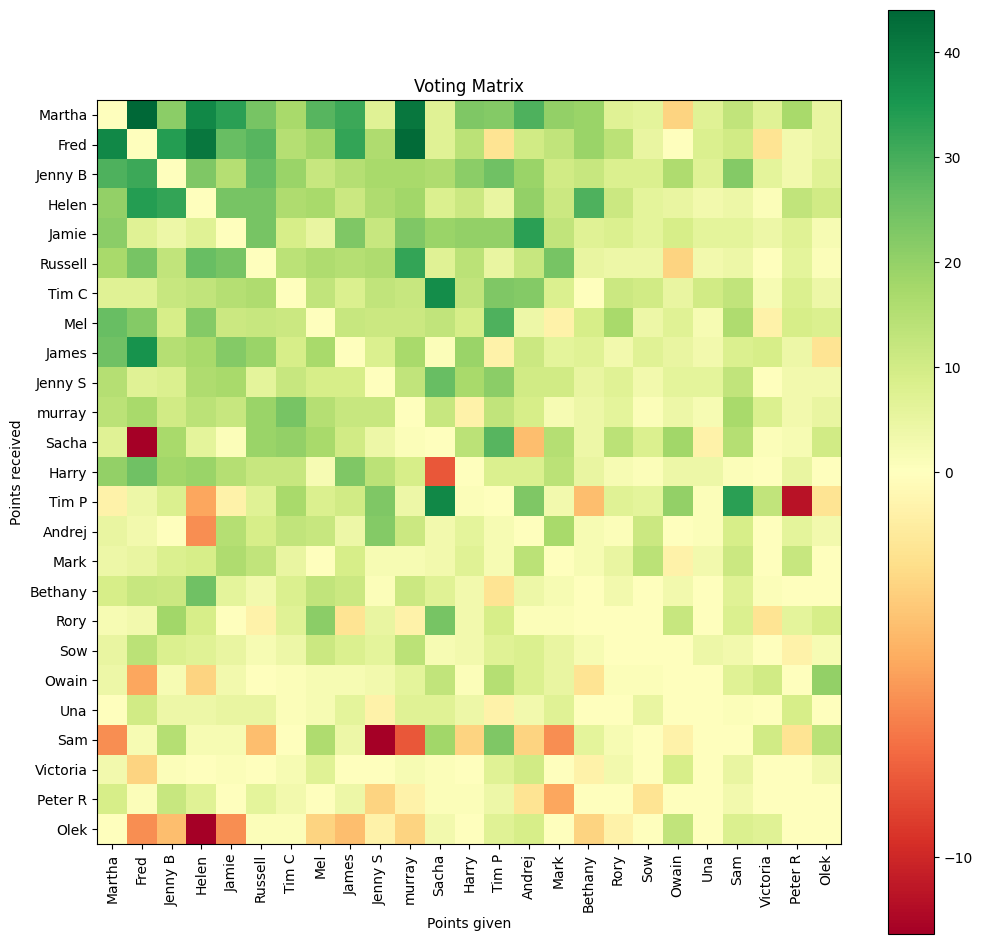

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_matrix),
                        vcenter=0,
                        vmax=np.max(voting_matrix))

plt.imshow(voting_matrix, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.xlabel("Points given")
plt.ylabel("Points received")
plt.title("Voting Matrix")


cbar = plt.colorbar()

plt.show()

In [ ]:
# Biggest differences 

reciprocals = np.abs((np.triu(voting_matrix) - np.tril(voting_matrix).T))
diffs = np.unravel_index(np.argsort(reciprocals.reshape(-1))[::-1][:10], reciprocals.shape)

for row, col in zip(*diffs):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

murray for Martha: 41
murray for Fred: 43
Andrej for Helen: 20
Sam for Jenny S: 13
Sam for murray: 17
Andrej for Martha: 29
Tim P for Martha: 22
Sacha for Jenny S: 26
Olek for Helen: 10
Harry for Sacha: 14


### Biggest Stans and biggest haters

In [ ]:
biggest_haters = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[::-1][:10], voting_matrix.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Fred for Martha: 44
murray for Fred: 43
Helen for Fred: 41
murray for Martha: 41
Martha for Fred: 38
Sacha for Tim P: 38
Helen for Martha: 38
Sacha for Tim C: 37
Fred for James: 36
Jenny B for Fred: 34


In [ ]:
biggest_haters = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[:10], voting_matrix.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Helen for Olek: -12
Jenny S for Sam: -12
Fred for Sacha: -12
Peter R for Tim P: -11
murray for Sam: -8
Sacha for Harry: -8
Martha for Sam: -6
Fred for Olek: -6
Helen for Andrej: -6
Mark for Sam: -6


## Voting Correlation

This shows who votes similarly, and who doesn't. Note that the matrix is symmetrical

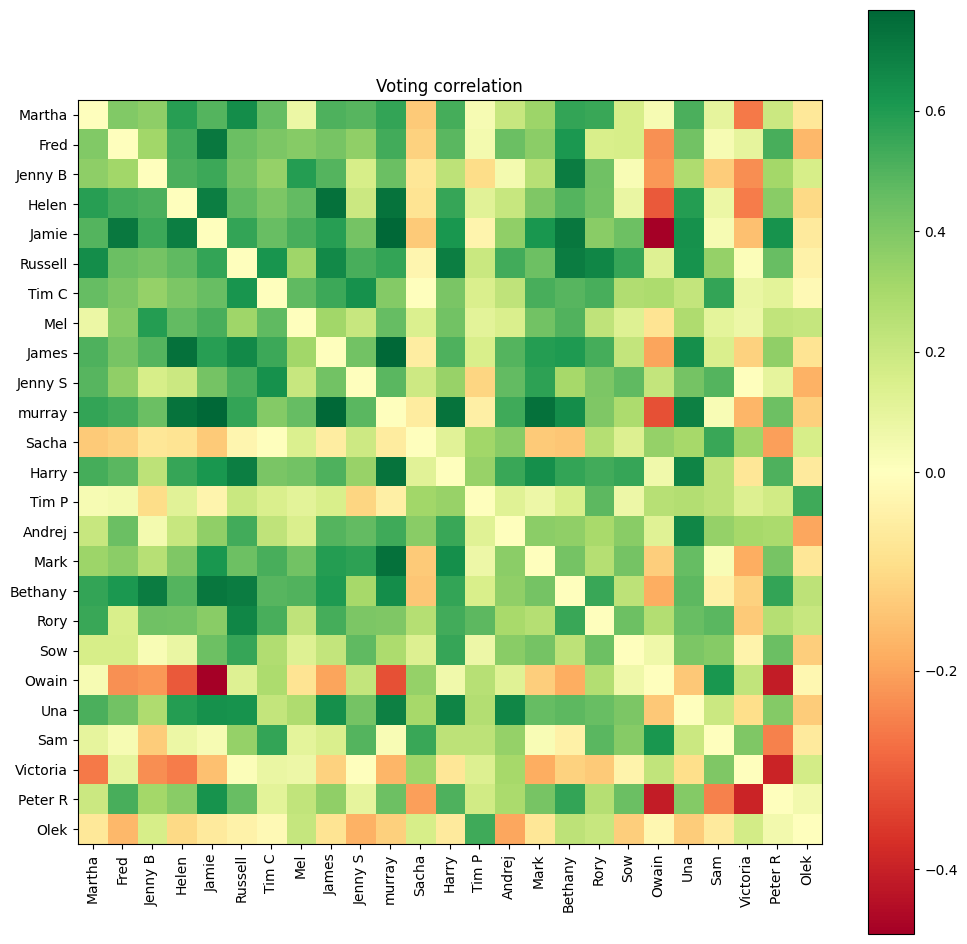

In [ ]:
# Sort arr into an array that's lists of each competitors votes per round

voting_correlation = np.corrcoef(np.vstack(voting_matrix).T)
np.fill_diagonal(voting_correlation, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_correlation),
                        vcenter=0,
                        vmax=np.max(voting_correlation))

plt.imshow(voting_correlation, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.title("Voting correlation")


cbar = plt.colorbar()

plt.show()

### Most and least voting-correlated

In [ ]:
most_correlated = np.unravel_index(np.argsort(-voting_correlation.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*most_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_correlation[row, col]:.2f}")

murray and James: 0.77
Jamie and murray: 0.76
Helen and James: 0.74
murray and Mark: 0.73
Harry and murray: 0.73
murray and Helen: 0.73
Bethany and Jamie: 0.71
Jamie and Fred: 0.71
Bethany and Jenny B: 0.70
Russell and Bethany: 0.70


In [ ]:
least_correlated = np.unravel_index(np.argsort(voting_correlation.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*least_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_correlation[row, col]:.2f}")

Jamie and Owain: -0.46
Owain and Peter R: -0.41
Victoria and Peter R: -0.39
Owain and murray: -0.32
Helen and Owain: -0.31
Martha and Victoria: -0.26
Victoria and Helen: -0.25
Peter R and Sam: -0.25
Jenny B and Victoria: -0.23
Fred and Owain: -0.23


## Genre Correlation

See who submitted similar genres. Note that Spotify's list of genres is pretty wild, so this is pretty rough

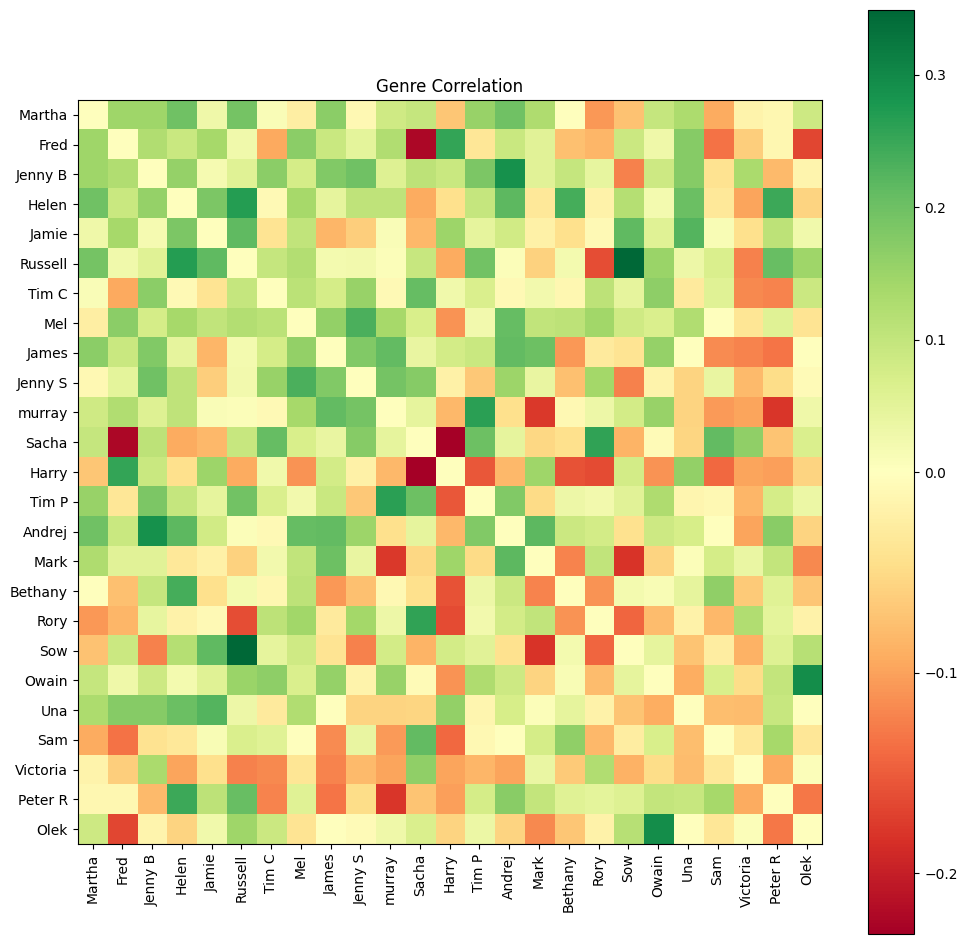

In [ ]:
unique_genres = set()

for submitter in winning_order:
    rest = set(reduce(add, df[df.submitter != submitter]["genres"].values))
    unique_genres |= set(reduce(add, df[df.submitter == submitter]["genres"])).difference(rest)

all_genres = list({genre for genres in df.genres for genre in genres}.difference(unique_genres))

x = df.groupby("submitter")["genres"].apply(lambda x: reduce(add, x)).reindex(winning_order).map(set)

genre_matrix = np.zeros((len(winning_order), len(all_genres)))

for i, genres in enumerate(x.values):
    for j, genre in enumerate(all_genres):
        if genre in genres:
            genre_matrix[i][j] = 1.0

voting_matrix = np.corrcoef(genre_matrix)
np.fill_diagonal(voting_matrix, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_matrix),
                        vcenter=0,
                        vmax=np.max(voting_matrix))

plt.imshow(voting_matrix, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.title("Genre Correlation")


cbar = plt.colorbar()

plt.show()

### Most and least genre correlated

In [ ]:
most_genre_correlated = np.unravel_index(np.argsort(-voting_matrix.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*most_genre_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_matrix[row, col]:.2f}")

Russell and Sow: 0.35
Olek and Owain: 0.29
Andrej and Jenny B: 0.29
Russell and Helen: 0.27
murray and Tim P: 0.26
Rory and Sacha: 0.26
Harry and Fred: 0.25
Helen and Peter R: 0.25
Bethany and Helen: 0.24
Mel and Jenny S: 0.23


In [ ]:
least_genre_correlated = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*least_genre_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_matrix[row, col]:.2f}")

Sacha and Harry: -0.23
Sacha and Fred: -0.22
Sow and Mark: -0.18
Peter R and murray: -0.18
Mark and murray: -0.18
Olek and Fred: -0.17
Rory and Harry: -0.16
Rory and Russell: -0.16
Bethany and Harry: -0.16
Harry and Tim P: -0.15


## Average positive vote given out

Look at who chunks their votes into lumps vs those who scatter their votes like chicken feed

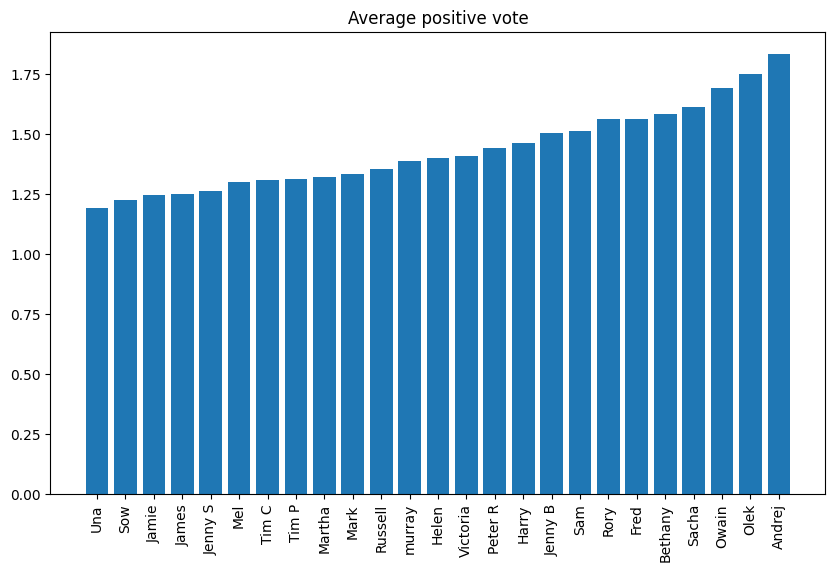

In [ ]:
x = arr.reshape(-1, len(winning_order))
x[x <= 0.0] = np.nan
a = np.nanmean(x, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Average positive vote")

ax.bar(np.arange(len(winning_order)), a[np.argsort(a)])
ax.set_xticks(np.arange(len(winning_order)), labels=[winning_order[i] for i in np.argsort(a)], rotation="vertical")

plt.show()

## Average song age

Plot every players average song age with respect to today (or when this notebook was run). Note that the accuracy of date on some songs is worse than others (year vs month vs day, so this isn't 100% accurate)

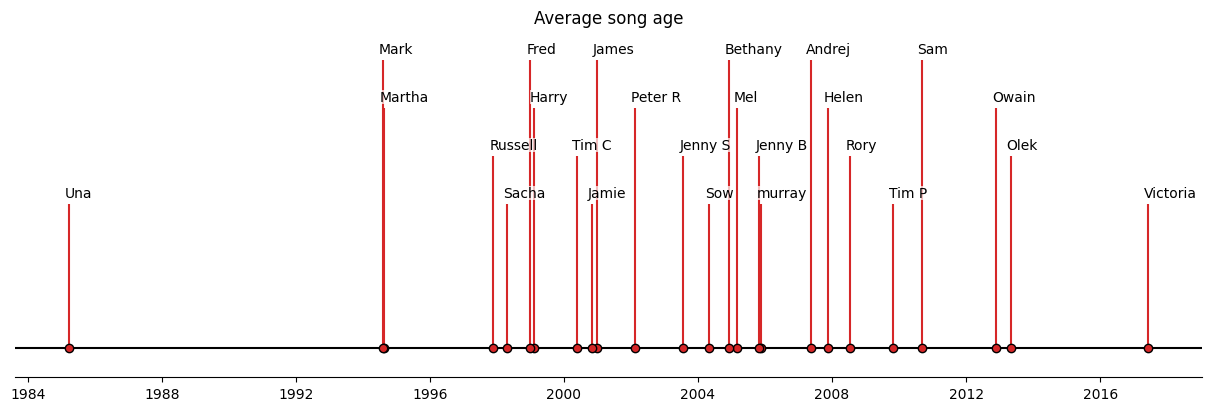

In [ ]:
df["song_age_seconds"] = (datetime.now() - df["release_date"]).dt.total_seconds()
ages = df.groupby("submitter")["song_age_seconds"].mean().sort_values().map(lambda x: datetime.now() - timedelta(seconds=x))

fig, ax = plt.subplots(figsize=(12, 4), layout="constrained")
ax.set(title="Average song age")

levels = [(i % 4) / 3 + 1 for i in range(len(ages))]

# The vertical stems.
ax.vlines(ages, 0, levels,
          color=[("tab:red", 1)
                 for _ in ages])
# The baseline.
ax.axhline(0, c="black")
# The markers on the baseline
ax.plot(ages, np.zeros_like(ages), "ko", mfc="tab:red")

# Annotate the lines.
for date, level, name in zip(ages, levels, ages.index):
    ax.annotate(name, xy=(date, level),
                xytext=(-3, np.sign(level)*3), textcoords="offset points",
                verticalalignment="bottom" if level > 0 else "top",
                bbox=dict(boxstyle='square', pad=0, lw=0, fc=(1, 1, 1, 0.7)))

ax.yaxis.set(major_locator=mdates.YearLocator(),
             major_formatter=mdates.DateFormatter("%Y"))

# Remove the y-axis and some spines.
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

In [ ]:
oldest = df.groupby("submitter")["song_age_seconds"].max().apply(lambda x: datetime.now() - timedelta(seconds=x)).sort_values()
youngest = df.groupby("submitter")["song_age_seconds"].min().apply(lambda x: datetime.now() - timedelta(seconds=x)).sort_values()

oldest_oldest = df.iloc[df[df["submitter"] == oldest.index[0]]["song_age_seconds"].idxmax()][["submitter", "release_date", "song_name"]]
youngest_oldest = df.iloc[df[df["submitter"] == oldest.index[-1]]["song_age_seconds"].idxmax()][["submitter", "release_date", "song_name"]]
youngest_youngest = df.iloc[df[df["submitter"] == youngest.index[-1]]["song_age_seconds"].idxmin()][["submitter", "release_date", "song_name"]]
oldest_youngest = df.iloc[df[df["submitter"] == youngest.index[0]]["song_age_seconds"].idxmin()][["submitter", "release_date", "song_name"]]

print(oldest_youngest.to_list())


['Una', Timestamp('2007-12-28 00:00:00'), 'Here Comes the Hotstepper']


In [ ]:
# does song age correlate with overall position

np.corrcoef(np.c_[ages.reindex(winning_order).argsort(), np.arange(len(ages))].T)

array([[1.        , 0.42461538],
       [0.42461538, 1.        ]])

### Mean song length

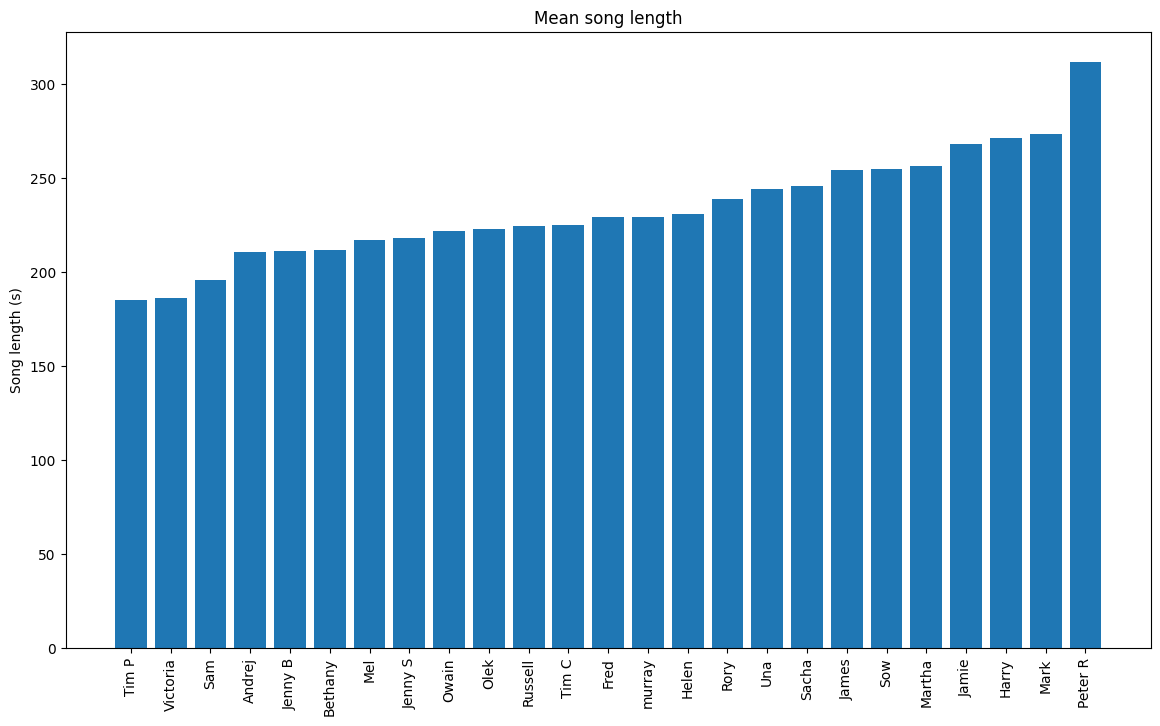

In [ ]:
lengths = df.groupby("submitter")["duration_s"].mean().sort_values()

fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(np.arange(len(lengths)), lengths)
ax.set_xticks(np.arange(len(winning_order)), lengths.index, rotation='vertical')
ax.set_title("Mean song length")
ax.set_ylabel("Song length (s)")
plt.show()

In [ ]:
# Correlation between mean song length and overall league rank
np.corrcoef(lengths.reindex(winning_order).rank(), np.arange(1, len(winning_order)+1))


array([[ 1.        , -0.10769231],
       [-0.10769231,  1.        ]])

### Longest and shortest songs

In [ ]:
df.sort_values("duration_s", ascending=False)[["submitter", "song_name", "duration_s"]].iloc[:10]

,submitter,song_name,duration_s
143,Russell,Blue Room,1053.813
680,Jamie,Mogwai Fear Satan,979.560
201,Harry,"The Curtain - Live From Dordrecht, Het Energie...",909.106
378,Harry,Zombie,745.653
399,Peter R,"Polovtsian Dances From ""Prince Igor""",690.306
539,Rory,Black No. 1 (Little Miss Scare -All),675.653
575,Peter R,"Ghandi, Dalai Lama, Your Lord & Savior J.C. / ...",615.028
145,James,Never Gonna Reach Me - Hot Toddy Remix,580.363
445,Mark,I Love You... I'll Kill You,532.560
774,Peter R,Movement 6,530.894


In [ ]:
df.sort_values("duration_s", ascending=True)[["submitter", "song_name", "duration_s"]].iloc[:10]

,submitter,song_name,duration_s
9,Tim C,Short Attention Span,8.888
15,Rory,Girl Fight,15.472
633,Sacha,I Am a Banana,39.026
280,Tim P,Theme from Strictly Come Dancing,42.000
446,Tim P,Swiper No Swiping!,46.106
406,Tim P,Mission: Impossible Theme,51.800
147,Victoria,Baby Park,55.500
408,James,The Best A Man Can Get (Gillette),60.000
627,Russell,Porcupine or Pineapple,64.825
710,Russell,Come On!,68.133


## Rankings if only downvotes/upvotes counted

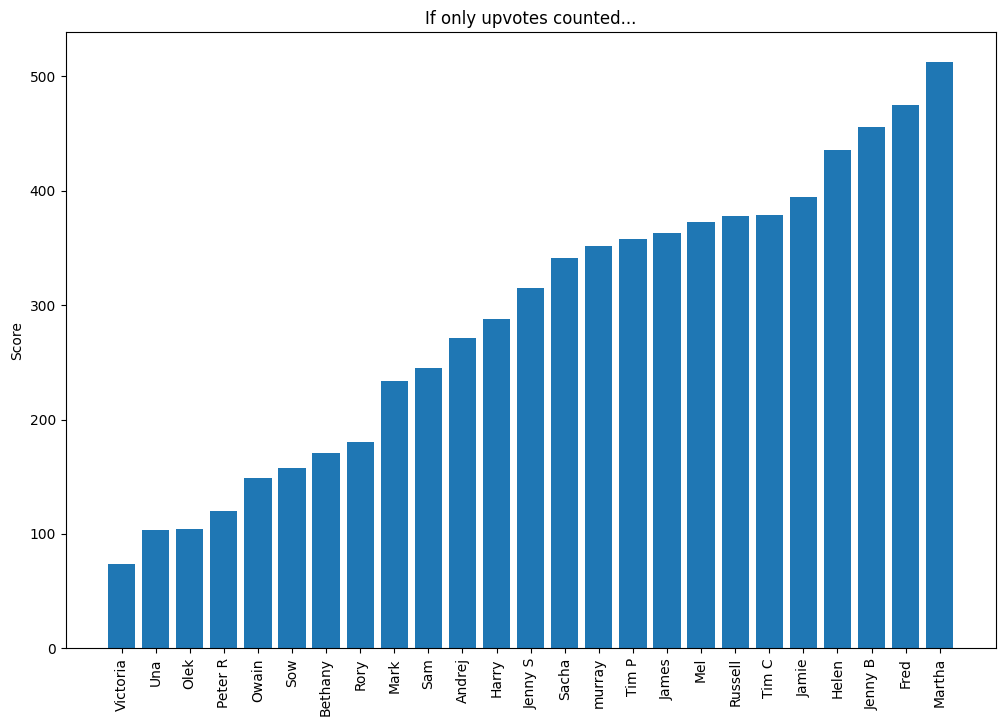

In [ ]:
positive_votes = np.where(arr > 0, arr, 0)

positive_scores = np.sum(positive_votes, axis=(0, 2))

order = np.argsort(positive_scores)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(len(winning_order)), np.sort(positive_scores))
ax.set_xticks(range(len(winning_order)), [winning_order[i] for i in order], rotation="vertical")
ax.set_ylabel("Score")
ax.set_title("If only upvotes counted...")

plt.show()

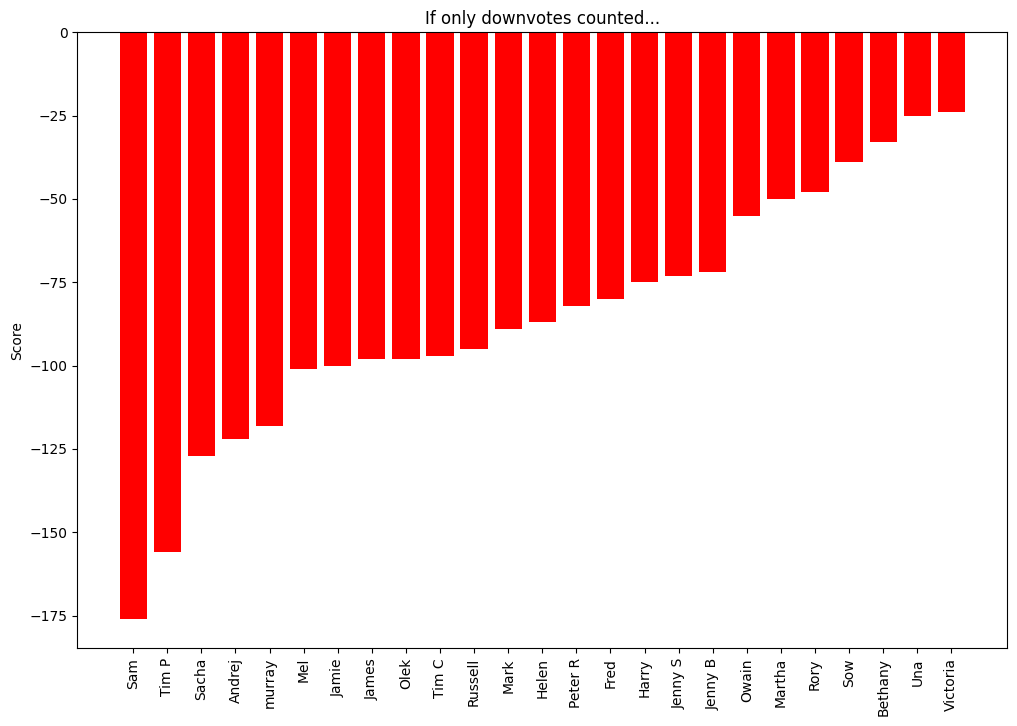

In [ ]:
negative_votes = np.where(arr < 0, arr, 0)

negative_scores = np.sum(negative_votes, axis=(0, 2))

order = np.argsort(negative_scores)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(len(winning_order)), np.sort(negative_scores), color="red")
ax.set_xticks(range(len(winning_order)), [winning_order[i] for i in order], rotation="vertical")
ax.set_ylabel("Score")
ax.set_title("If only downvotes counted...")

plt.show()

## Controversy score

The controversy score aims to find the most controversial songs, those with the highest numbers of upvotes and downvotes leaving a score near 0

The controversy score $C$ is calculated using the following formula:


$C = \sqrt{\frac{1}{N_{\neq 0}} \sum_{i=1}^{N_{\neq 0}} (v_i - \mu)^2} \times \left( \sum_{i=1}^{n} v_i \text{ where } v_i > 0 \ - \ \alpha \sum_{i=1}^{n} v_i \text{ where } v_i < 0 \right)$


Where:
- $v_i$ are the individual votes.
- $\mu$ is the mean of the non-zero votes.
- $N_{\neq 0}$ is the number of non-zero votes.
- $\alpha$ is the ratio of positive to negative votes ($\frac{10}{3}$ in this league)
- The first part of the equation represents the standard deviation of the non-zero votes.
- The second part represents a modified range that accounts for positive and scaled negative votes.


/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


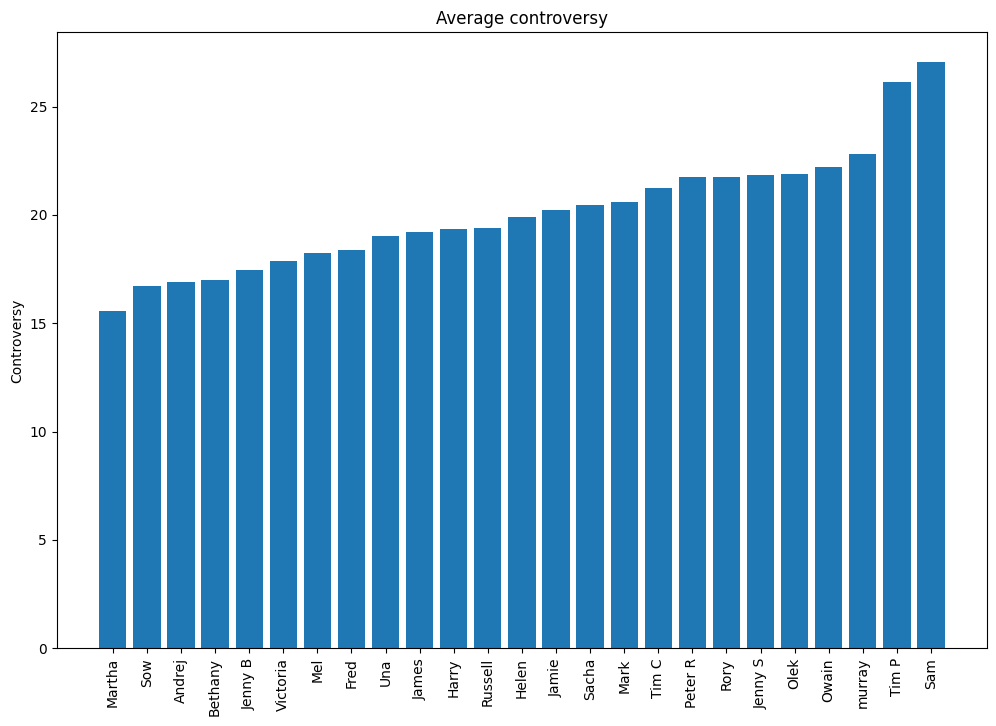

In [ ]:
def controversy(vals):
    std = np.std([i for i in vals if i])
    range = sum(i for i in vals if i > 0.0) - (sum(i for i in vals if i < 0.0) * 10/3)
    return std * range

df["controversy"] = df[names].fillna(0).apply(controversy, axis=1)
df.sort_values("controversy", ascending=False)[["submitter", "song_name", "round", "controversy"]].iloc[:10]

fig, ax = plt.subplots(figsize=(12, 8))

vals = df.groupby("submitter")["controversy"].mean().sort_values()

ax.bar(np.arange(len(vals)), vals)
ax.set_xticks(range(len(vals)), vals.index, rotation="vertical")
ax.set_ylabel("Controversy")
ax.set_title("Average controversy")

plt.show()

In [ ]:
df.sort_values("controversy", ascending=False)[["controversy", "submitter", "round", "song_name"]].iloc[:10]

,controversy,submitter,round,song_name
466,116.833214,Sam,Colours 🎨,"Love Me Like You Do (From ""50 Shades of Grey"")..."
327,87.689741,Sam,One hit wonder 🌟,Imagine - Remastered 2010
142,87.062132,Sam,Songs to code to 👩‍💻,Screaming Man - Sound Effect
179,83.486339,Fred,Yesteryear 📅,Padam Padam
1,81.649658,Jamie,120 seconds to go ⏱,Golden Slumbers - Remastered 2009
519,71.527709,murray,Musicals 🎭,Hard Candy Christmas
37,71.154154,James,Cover🎪,Bohemian Rhapsody
53,71.045525,Sam,Eurovision💶👀,Bono's a Fucking Cunt
201,69.565516,Harry,Best live version 🎤,"The Curtain - Live From Dordrecht, Het Energie..."
680,64.466759,Jamie,🎸 Best instrumental,Mogwai Fear Satan


In [ ]:
print("Number of explicit songs submitted")
df.groupby("submitter")["explicit"].sum().sort_values(ascending=False)

Number of explicit songs submitted


submitter
Mel         10
Sacha        9
murray       8
Tim P        7
Sam          6
Jenny B      6
Tim C        6
Russell      6
Bethany      6
Fred         5
Jamie        4
James        4
Rory         4
Martha       3
Helen        3
Jenny S      2
Owain        2
Olek         2
Andrej       1
Victoria     1
Sow          1
Harry        0
Mark         0
Peter R      0
Una          0
Name: explicit, dtype: int64

In [ ]:
# Every explicit song
df[df["explicit"]][["submitter", "round", "song_name", "artist_names"]]

,submitter,round,song_name,artist_names
4,Sam,120 seconds to go ⏱,Freaks to the Front,[Amyl and The Sniffers]
8,Victoria,120 seconds to go ⏱,say goodbye,[Sarcastic Sounds]
13,Helen,120 seconds to go ⏱,BIZCOCHITO,[ROSALÍA]
16,Bethany,120 seconds to go ⏱,Degradation,[Gorilla Biscuits]
20,Bethany,Cover🎪,Killing Me Softly With His Song,"[Fugees, Ms. Lauryn Hill]"
...,...,...,...,...
757,James,🤝 Most surprising collaboration,Numb / Encore,"[JAY-Z, Linkin Park]"
759,Sow,🤝 Most surprising collaboration,Natalie’s Rap 2.0 (feat. Natalie Portman),"[The Lonely Island, Natalie Portman]"
761,Mel,🤝 Most surprising collaboration,Don't Hurt Yourself (feat. Jack White),"[Beyoncé, Jack White]"
768,Tim P,🤝 Most surprising collaboration,Sorry Not Sorry (with Slash) - Rock Version,"[Demi Lovato, Slash]"
